In [10]:

#from break_capt import minivggnet
#---sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#---tensorflow
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from imutils import contours
from imutils import paths
#---others
import matplotlib.pyplot as plt
import numpy as np
import imutils
import argparse
import cv2
import os
import seaborn as sns

### 1. Get the data

In [3]:
#the dataset can be downaloaded from "https://www.e-zpassny.com/vector/jcaptcha.do"
imagePaths = list(paths.list_images("...\downloads"))

[]

### 2. Extract the numbers from the images

In [5]:
counts = {}
#preprocess all the images
for (i, imagePath) in enumerate(imagePaths):
    try:
        image = cv2.imread(imagePaths)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE) #pad the images so, when extracting the numbers, the border of the image is also kept
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)[1] #combine thresholds to obtaing the shape and then soften the noise
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea,reverse=True)[:4]
    for c in cnts:
        (x,y,w,h) = cv2.boundingRect(c) #for each number, draw a bounding box and extract its coordinates
        roi= gray[y-5 : y+h+5 , x-5 : x+w+5 ] #define the roi by adding some extra space to the image
        #Assign labels to the numbers
        cv2.imshow("ROI", imutils.resize(roi, width=28))
        key = cv2.waitKey(0) #assign a number tothe hey variable according to the number pressed with the keyboard
        if key == ord("`"):# if key ` is presed, ignore
            print("[INFO] ignoring character")
            continue
        key = chr(key).upper()
        dirPath = os.path.sep.join(["...\annotations", key])
        #if the path does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
        count = counts.get(key, 1)
        print(count)
        p = os.path.sep.join([dirPath, "{}.png".format(str(count).zfill(6))]) #add six 0 to the name of the image by default and fill them with the numbers
        cv2.imwrite(p, roi) #save the image
        counts[key] = count + 1 #up the count so to not replace the already saved images
    cv2.destroyAllWindows() #so it doesn't get stuck

    # except KeyboardInterrupt:
    #     print("[INFO] manually leaving script")
    #     break

	# # an unknown error has occurred for this particular image
	# except:
	# 	print("[INFO] skipping image...")

[]

### 3. Preprocessing function

In [3]:
def preprocess(image, width, height):
	(h, w) = image.shape[:2]
	if w > h: #in case the width is larger than the heigh. So to avoid deformation in size
		image = imutils.resize(image, width=width)
	else:
		image = imutils.resize(image, height=height)

	padW = int((width - image.shape[1]) / 2.0) #add some extrapadding on both sides
	padH = int((height - image.shape[0]) / 2.0)

	image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
	image = cv2.resize(image, (width, height)) #resize one more time just to avoid any issues
    
	return image

In [4]:
data = []
labels = []

In [5]:
#extarct the labels
for imagePath in paths.list_images("...\annotations"):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = preprocess(image, 28, 28)
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

### 4. Visualize the data

<AxesSubplot:>

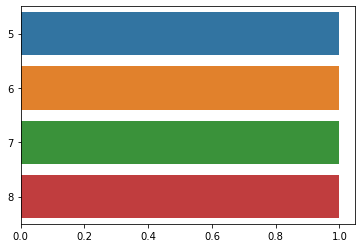

In [22]:
sns.barplot(y=labels, x = [labels.count(i) for i in labels])

### 5. Train the model

In [ ]:
#Scale the raw pixels to range [0,1] since NN require this range
data = np.array(data, dtype="float")/255.0
labels = np.array(labels)

In [ ]:
#separate data to train and test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [ ]:
#Convert the labels to one hot encodings
trainY = LabelBinarizer.fit_transform(trainY)
testY = LabelBinarizer.transform(testY)

In [ ]:
#inititalize the model
model = minivggnet.build(width=28, height=28, depth=1, classes=9)
opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
#train model
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs= 15, verbose=1)

In [ ]:
#get the predictions
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

In [ ]:
# Save the model
model.save("...\best_capt.hdf5")

In [ ]:
plt.figure()
plt.plot(np.arange(0,15), H.hisstory["loss"], labels="train_loss")
plt.plot(np.arange(0,15), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,15), H.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()